In [6]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'AppleGothic'

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [7]:
import pandas as pd

# 데이터 불러오기
all_data=pd.read_csv('data/df_traditional.csv')
all_data.columns = all_data.columns.str.strip()
all_data = all_data[['TEAM_WITH_SEASON'] + [col for col in all_data.columns if col != 'TEAM_WITH_SEASON']]

## 선수단에 대한 eda

In [8]:
min_25_players = all_data[all_data['MIN'] >= 25].groupby(['SEASON', 'TEAM']).size()
min_15_25_players = all_data[(all_data['MIN'] >= 15) & (all_data['MIN'] < 25)].groupby(['SEASON', 'TEAM']).size()

# 15분 뛴 선수, 25분 뛴 선수가 한 팀에 얼마나 있는지
avg_min_25 = min_25_players.mean()
avg_min_15 = min_15_25_players.mean()
print(avg_min_25) 
print(avg_min_15)

5.144314868804665
4.116959064327485


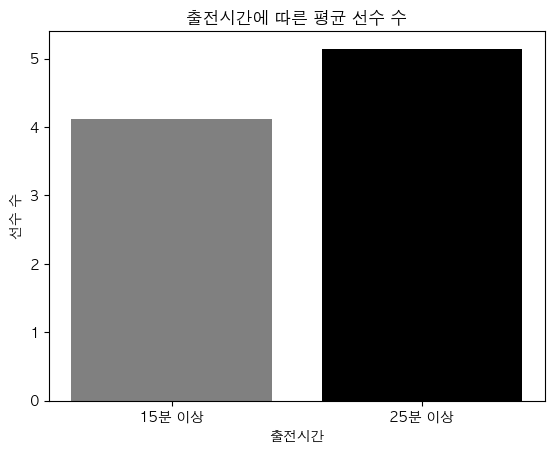

In [10]:
import matplotlib.pyplot as plt

# 15분 이상 25분 미만, 25분 이상 뛴 선수 수의 평균을 리스트로 저장
avg_players = [avg_min_15, avg_min_25]
labels = ['15분 이상', '25분 이상']

# 막대그래프 생성
plt.bar(labels, avg_players, color=['gray', 'black'])
plt.xlabel('출전시간')
plt.ylabel('선수 수')
plt.title('출전시간에 따른 평균 선수 수')

# 그래프 출력
plt.show()


- 대략 선발 5명 교체 4명으로 명단을 구성하면 될 것 같음 

In [11]:
# 25분 이상 뛰는 선수들의 TOTAL_MIN 합 계산
total_min_25min = all_data[all_data['MIN'] >= 25].groupby(['SEASON', 'TEAM'])['TOTAL_MIN'].sum()
total_min_15min = all_data[(all_data['MIN'] >= 15) & (all_data['MIN'] < 25)].groupby(['SEASON', 'TEAM'])['TOTAL_MIN'].sum()
total_min_5min = all_data[(all_data['MIN'] >= 5) & (all_data['MIN'] < 15)].groupby(['SEASON', 'TEAM'])['TOTAL_MIN'].sum()

# 전체 선수들의 TOTAL_MIN 합 계산
total_min_all_players = all_data.groupby(['SEASON', 'TEAM'])['TOTAL_MIN'].sum()

# 비율 계산 (25분 이상 뛰는 선수의 TOTAL_MIN 합 / 전체 선수의 TOTAL_MIN 합)
x=total_min_25min / total_min_all_players
y=total_min_15min / total_min_all_players
z=total_min_5min / total_min_all_players


x.values.mean() # 25분넘게 뛴 선발이 63퍼센트정도 차지함 
np.nanmean(y.values) # 15분 넘게 뛴 선수가 30퍼센트정도 차지함 
np.nanmean(z.values) # 5분 넘게 뛴 선수가 7퍼센트정도 차지함 

0.07435475733346204

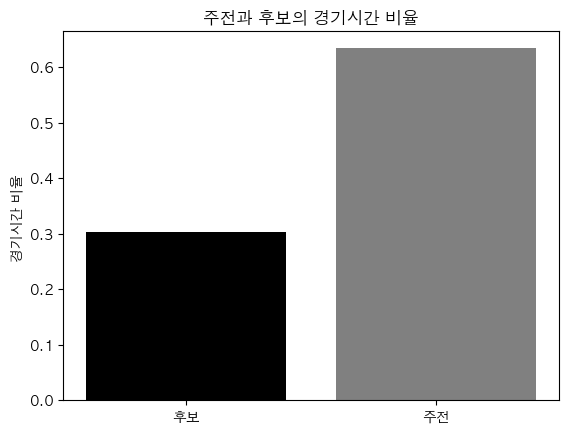

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 25분, 15분, 5분 이상 뛴 선수들의 비율 계산
values = [ np.nanmean(y.values),x.values.mean()]
labels = ['후보','주전']

# 막대그래프 생성
plt.bar(labels, values, color=[ 'black','gray'])
plt.xlabel('')
plt.ylabel('경기시간 비율 ')
plt.title('주전과 후보의 경기시간 비율')

# 그래프 출력
plt.show()

In [5]:
np.nanmean(y.values) # 15분 넘게 뛴 선수가 30퍼센트정도 차지함 

0.3035442771386922

In [6]:
np.nanmean(z.values) # 5분 넘게 뛴 선수가 7퍼센트정도 차지함 

0.07435475733346204

In [7]:
zmean=all_data[(all_data['MIN'] >= 5) & (all_data['MIN'] < 15)].groupby(['SEASON', 'TEAM'])['PTS'].mean()
np.nanmean(zmean.values) # 7퍼센트 차지하는 선수들이 평균 4점 정도 넣는 것으로 보아, 팀에 큰 기여를 하지 않는다고 생각

3.8537592277115276

- 위 결과를 고려했을 때, 선발을 65퍼센트를 5명으로, 나머지 35퍼센트에 대해 후보들 4~5명 정도로 구성하면 될 것이라고 결정


## 클러스터링이 얼마나 잘 되었는지 확인 
1. 각 클러스터별 해석을 포지션으로 해석하여 => 모든 클러스터가 필요함을 명시
2. 클러스터별 급여를 구하여 평균급여가 특정 클러스터가 높기 때문에 몰빵되면 안됨을 명시 
3. 클러스터링 해석이 잘 됐음을 보여주기 위해 클러스터별 rate를 구하여 비교한다. 
4. 클러스터별 선수를 직접 확인함

In [28]:
import pandas as pd 
import  seaborn.objects as so
df=pd.read_csv('data/final_salary_cluster.csv')
df.head()
df.rename(columns={'전체적인 평점': 'rate'}, inplace=True)

In [29]:
x.values

array([ 9580670.54545454,  7000599.05882353, 18680546.62222222,
       13257419.45      ,  7662206.6875    ,  9203968.81944444])

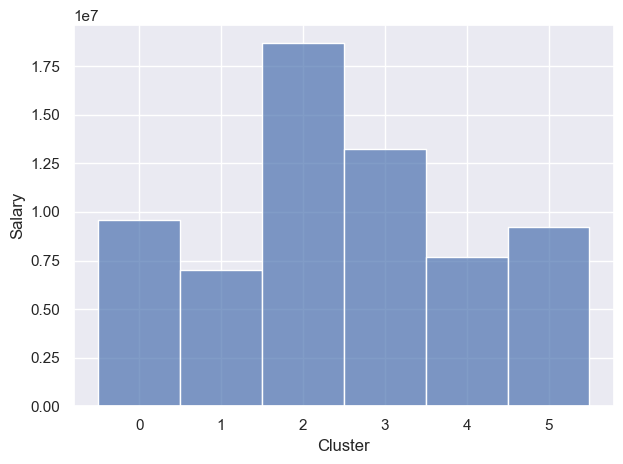

In [30]:
# 데이터 준비
x = df.groupby('Cluster')['Salary'].mean()

# Seaborn Objects를 사용하여 Bar Plot 생성
plot = (
    so.Plot(x.reset_index(), x='Cluster', y='Salary')
    .add(so.Bars())
)
plot.show()

In [36]:
x.mean()

10897568.530574122

- 2,3 클러스터가 엘리트 클러스터며 가장 평균적으로 급여를 많이 받는 것으로 보아 잘 클러스터링된 것을 확인할 수 있다.
- 이전 클러스터별로 센터, 슛팅 가드, 수비 가드, 엘리트 등 특정 포지션에 특화되어 있는 것으로 나타났음
- 모든 좋은 평점을 갖는 선수는 비싼것으로 확인되기 때문에 모든 클러스터에서 조화롭게 선수단을 구성하는게 중요하다고 생각됨 

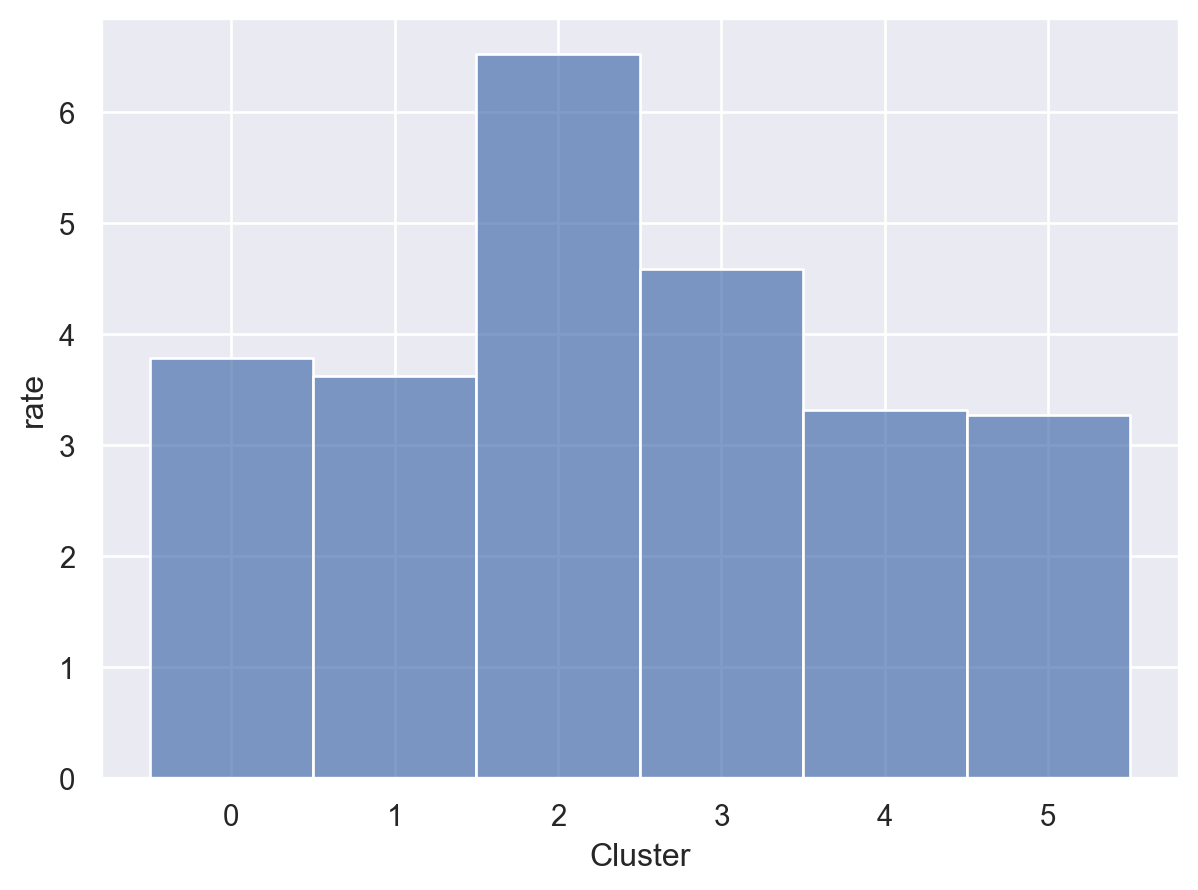

In [34]:
y = df.groupby('Cluster')['rate'].mean()
(
    so.Plot(y.reset_index(), x='Cluster', y='rate')
    .add(so.Bars())
)

- 성과가 높은 선수들이 엘리트선수쪽에 몰려있는 것으로 보아 클러스터링이 잘 된 것을 볼 수 있다.

- **Cluster 0**: 수비엘리트 가드, 수비형,패스형
- **Cluster 1**: 조력자 역할하는 포워드
- **Cluster 2**: 엘리트 가드
- **Cluster 3**: 엘리트 포워드
- **Cluster 4**: 리바운드 및 페인트존 중심의 전통 센터형
- **Cluster 5**: 외곽 슈터

In [41]:
df[df['Cluster']==0].head()
# 수비형 선수 
# 실제로 jrue holiday는 2023년 디펜스 퍼스트팀에 뽑힌 수비에 특화되어 있는 가드이다.

,PLAYER,SEASON,TEAM,Cluster,MIN,rate,Salary
33,Kyle Kuzma,2022-23,WAS,0,35.0,7.624841,13000000.0
45,Kelly Oubre Jr.,2022-23,CHA,0,32.2,6.370156,12600000.0
52,Jrue Holiday,2022-23,MIL,0,32.6,8.322795,34319520.0
53,Kevin Porter Jr.,2022-23,HOU,0,34.3,7.747722,3200000.0
55,Jaren Jackson Jr.,2022-23,MEM,0,28.4,5.960208,9180560.0


In [43]:
df[df['Cluster']==1].head()
# 바그너 , 워싱턴, 반스 모두 선발 및 식스맨 멤버로 포워드로서 좋으 활약을 보임 

,PLAYER,SEASON,TEAM,Cluster,MIN,rate,Salary
34,Terry Rozier,2022-23,CHA,1,35.3,7.634911,21486316.0
41,Dejounte Murray,2022-23,ATL,1,36.4,7.569887,17071120.0
56,Franz Wagner,2022-23,ORL,1,32.6,8.155521,5258280.0
74,P.J. Washington,2022-23,CHA,1,32.6,6.082363,5808435.0
80,Harrison Barnes,2022-23,SAC,1,32.5,6.400638,18352273.0


In [45]:
df[df['Cluster']==2].head()
# 릴라드, 부커, 미첼은 상위권 팀의 선발 가드이며, 엠비드와 제임스는 센터및 포워드 능력뿐 아니라 패싱센스도 겸비한 선수들

,PLAYER,SEASON,TEAM,Cluster,MIN,rate,Salary
0,Joel Embiid,2022-23,PHI,2,34.6,13.005240,33616770.0
1,Damian Lillard,2022-23,POR,2,36.3,11.731272,42492492.0
7,LeBron James,2022-23,LAL,2,35.5,10.682915,44474988.0
8,Donovan Mitchell,2022-23,CLE,2,35.8,11.029939,30913750.0
9,Devin Booker,2022-23,PHX,2,34.6,10.833176,33833400.0


In [46]:
df[df['Cluster']==3].head()
# 듀란트, 쿰보, 테이텀은 리바운드 능력이 뛰어난 mvp급 포워드이며, sga는 리바운드 능력이 뛰어난 mvp출신 가드이다.

,PLAYER,SEASON,TEAM,Cluster,MIN,rate,Salary
2,Shai Gilgeous-Alexander,2022-23,OKC,3,35.5,10.596915,30913750.0
3,Giannis Antetokounmpo,2022-23,MIL,3,32.1,15.068057,42492492.0
4,Jayson Tatum,2022-23,BOS,3,36.9,13.797792,30351780.0
5,Stephen Curry,2022-23,GSW,3,34.7,12.481710,48070014.0
6,Kevin Durant,2022-23,PHX,3,35.6,9.783448,44119845.0
